# Зависимости
Загружаем и импортируем все нужные библиотеки.

- **PIL** нужен для загрузки JPG и PNG изображений.
- **MXNet** нужен для оптимизации и загрузки предобученного VGG-16.
- **Matplotlib** нужен, чтобы рисовать картинки в ноутбуке.
- **NumPy** для определения типов и работы с Matplotlib.

In [0]:
%%capture
!pip install mxnet-cu100

In [0]:
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

import mxnet as mx
import mxnet.ndarray as nd
import mxnet.gluon as gluon
import mxnet.autograd as autograd

# Предобработка

Так как мы будем пользоваться предобученной VGG-16 на датасете ImageNet, то входные данные необходимо нормировать.

In [0]:
# ImageNet statistics for pretrained models
IMAGENET_MEAN = nd.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
IMAGENET_STD = nd.array([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)

1. Загружать картинки будем через Python Image Library.
2. Предобработка меняет порядок осей, чтобы сначала шли каналы потом положение пикселя $(x,y)$. Далее она приводит статистику пикселей к статистике ImageNet. И, наконец, добавляет фиктивную ось для номера примера в мини-батче (размера мини-батча равен одному).
3. Постобработка просто выполняет обратную предобработку.
4. Будем использовать `plt.imshow`, чтобы нарисовать картинку.

In [0]:
def load_image(filename):
    image = PIL.Image.open(filename).convert('RGB')
    return np.array(image)
  
def preprocess(image):
    normalized = nd.array(image).transpose((2, 0, 1)).astype(np.float32)
    normalized = nd.expand_dims(normalized, axis=0)
    return (normalized / 255.0 - IMAGENET_MEAN) / IMAGENET_STD
  
def deprocess(image):
    denormalized = 255.0 * (IMAGENET_STD * image + IMAGENET_MEAN)
    denormalized = denormalized[0]
    denormalized = denormalized.transpose((1, 2, 0)).astype(np.float32)
    return np.clip(denormalized.asnumpy(), 0, 255).astype(np.uint8)
    
def plot_images(images, titles=None):
    if titles == None:
        titles = (np.arange(len(images)) + 1).astype(str)

    plt.figure(figsize=(16,4))
    for idx in range(len(images)):
        plt.subplot(1, len(images), idx + 1)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title(titles[idx])
        plt.imshow(images[idx])
        
    plt.show()

# Модель переноса стиля

Чтобы перенести стиль с одного изображения на другое, необходимо использовать нейронную сеть для выделения высокоуровневых признаков, сеть-экстрактор. В нашем случае мы будем использовать активации промежуточных слоёв свёрточной сети VGG-16, а именно первых четырёх свёрточных слоёв, которые идут непосредственно перед MaxPooling.

*Стилизованное изображение находится градиентным спуском, начиная с изначального изображения, до тех пор, пока уровень стилизации не достигнет установленного значения.*

Целовой функцией будет сумма трёх функций потерь:

- **Потери содержания** — $l_2$ расстояние между активаций от стилизовааного изображения и изначального,
- **Потери стиля** — $l_2$ расстояние между матрицами Грамма активаций от стилизованного изображения и стиля,
- **Потери вариации**  — $l_2$ расстояние между вертикальными и горизонтальными сдвигами стилизованного изображения.

Для каждого случая приходиться отдельно подбирать весовые коэффициенты потерь, в зависимости от того, какие именно стилевые качества требуется перенести.

Загружаем VGG-16 и помещаем её веса на GPU.


In [5]:
vgg = gluon.model_zoo.vision.vgg16(pretrained=True, ctx=mx.gpu())

Нарезаем VGG-16 на блоки и определяем все функции потерь.

In [0]:
vgg_slices = [
    vgg.features[0:4],
    vgg.features[4:9],
    vgg.features[9:16],
    vgg.features[16:23]
]

def total_variation(x):
    horizontal = nd.mean(nd.square(x[:, :, 1:, :] - x[:, :, :-1, :]))
    vertical   = nd.mean(nd.square(x[:, :, :, 1:] - x[:, :, :, :-1]))
    return horizontal + vertical

def gram_matrix(image):
    (batch_size, channels, h, w) = image.shape
    flattened = image.reshape((batch_size, channels, w * h))
    gram = nd.batch_dot(flattened, flattened, transpose_b=True) 
    return gram / (channels * h * w)

def features(image):
    path = [image]
    for feed_forward in vgg_slices:
        path.append(feed_forward(path[-1]))

    content_features = path[1]
    style_features = [
        gram_matrix(path[1]),
        gram_matrix(path[2]),
        gram_matrix(path[3]),
        gram_matrix(path[4])
    ]
    
    return content_features, style_features

Итоговый цикл оптимизации изображения для переноса стиля будет выглядеть так.

In [0]:
def style_transfer(content_image, styly_image, style_wights, tv_weight=0.25, iterations=100, verbosity=None):
    if verbosity == None:
        verbosity = iterations + 1
    
    # preprocess images
    content = preprocess(content_image).as_in_context(mx.gpu())
    style = preprocess(style_image).as_in_context(mx.gpu())

    # cache content and style features
    content_target, _ = features(content)
    _, style_target = features(style)

    # make an output image and initalize it with content
    output = gluon.Parameter('output', shape=content.shape)
    output.initialize(ctx=mx.gpu())
    output.set_data(content)

    # define loss and optimizator
    trainer = gluon.Trainer([output], 'adam', {'learning_rate': 6e-2})
    mse = gluon.loss.L2Loss()
    
    # optimization loop
    for it in range(iterations):
        with autograd.record():
            content_features, style_features = features(output.data())
            content_loss = mse(content_target, content_features)

            style_loss = 0.0
            for idx in range(len(style_features)):
                style_loss = style_loss + style_wights[idx] * mse(style_target[idx], style_features[idx])

            tv_loss = tv_weight * total_variation(output.data())
            total_loss = style_loss + content_loss + tv_loss

        total_loss.backward()
        trainer.step(batch_size=1)
        
        # show intermidiate results
        if (it + 1) % verbosity == 0:
            print('it:', it + 1, '-- loss:', total_loss.asscalar())
            print('content:', content_loss.asscalar(), '-- style:', style_loss.asscalar(), '-- tv:', tv_loss.asscalar())
            plot_images([deprocess(output.data().as_in_context(mx.cpu()))])
            
    return deprocess(output.data().as_in_context(mx.cpu()))

# Результаты

Для начала загрузим картинки с Github

In [0]:
!mkdir images
!wget -q -P images/ \
    https://github.com/euav/style-transfer/raw/master/images/bricks.jpg \
    https://github.com/euav/style-transfer/raw/master/images/face.jpg \
    https://github.com/euav/style-transfer/raw/master/images/jojo.jpg \
    https://github.com/euav/style-transfer/raw/master/images/roof.png \
    https://github.com/euav/style-transfer/raw/master/images/space.jpg

Выберем картинки для проверки алгортима.

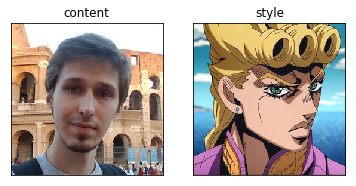

In [9]:
content_image = load_image('images/face.jpg')
style_image = load_image('images/jojo.jpg')
plot_images([content_image, style_image], ['content', 'style'])

it: 20 -- loss: 406.8944
content: 0.4111638 -- style: 404.0243 -- tv: 2.458943


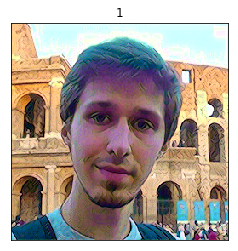

it: 40 -- loss: 95.06776
content: 0.5160048 -- style: 91.78575 -- tv: 2.7660012


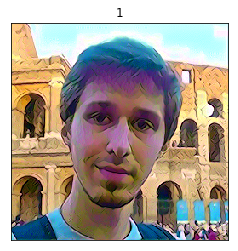

it: 60 -- loss: 45.571194
content: 0.54616904 -- style: 42.182148 -- tv: 2.842877


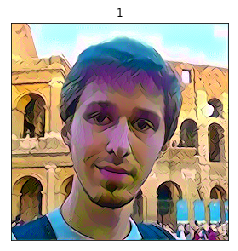

it: 80 -- loss: 30.018013
content: 0.55986226 -- style: 26.60576 -- tv: 2.8523896


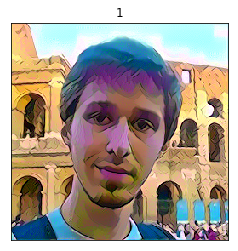

it: 100 -- loss: 23.193583
content: 0.57089466 -- style: 19.767729 -- tv: 2.8549597


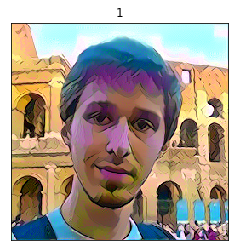

it: 120 -- loss: 19.253788
content: 0.579836 -- style: 15.8200035 -- tv: 2.8539495


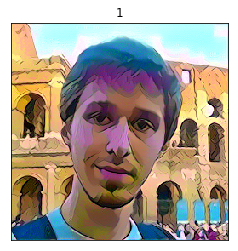

it: 140 -- loss: 16.623396
content: 0.5877028 -- style: 13.184725 -- tv: 2.8509686


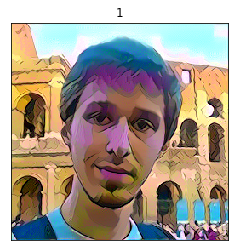

it: 160 -- loss: 14.723955
content: 0.59467244 -- style: 11.282774 -- tv: 2.8465095


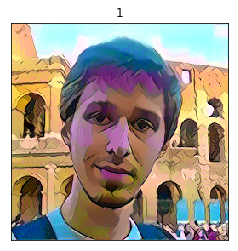

it: 180 -- loss: 13.285671
content: 0.6010592 -- style: 9.843112 -- tv: 2.8415


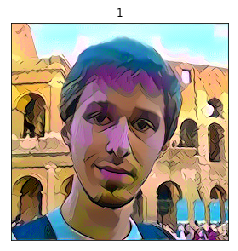

it: 200 -- loss: 12.162212
content: 0.60689676 -- style: 8.7195835 -- tv: 2.835732


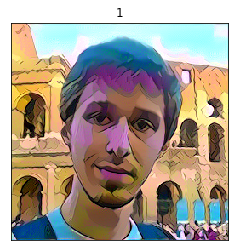

In [10]:
style_weights = 2e6 * np.array([100.0, 1.0, 0.1, 0.01])
output_image = style_transfer(content_image, style_image, style_weights, tv_weight=6, iterations=200, verbosity=20)

Теперь посмотрим, как алгоритм будет работать на других изображениях.

### Оконная мозаика

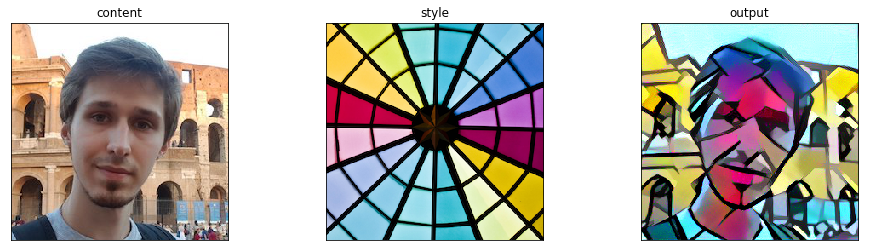

In [14]:
content_image = load_image('images/face.jpg')
style_image = load_image('images/roof.png')

style_weights = 2e7 * np.array([10.0, 1.0, 1.0, 1.0])
output_image = style_transfer(content_image, style_image, style_weights, tv_weight=10, iterations=500)
plot_images([content_image, style_image, output_image], titles=['content', 'style', 'output'])

### Кирпичная стена

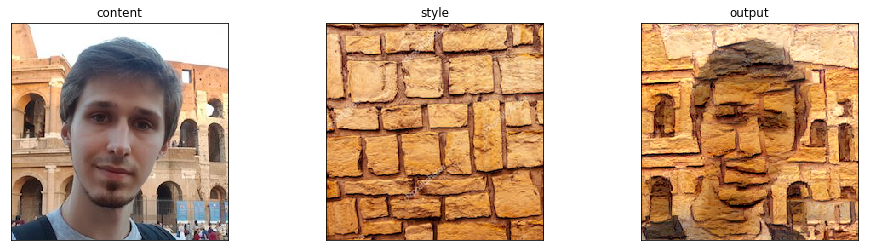

In [15]:
content_image = load_image('images/face.jpg')
style_image = load_image('images/bricks.jpg')

style_weights = 2e7 * np.array([1.0, 1.0, 1.0, 1.0])
output_image = style_transfer(content_image, style_image, style_weights, tv_weight=15, iterations=1000)
plot_images([content_image, style_image, output_image], titles=['content', 'style', 'output'])

### Звёздное небо

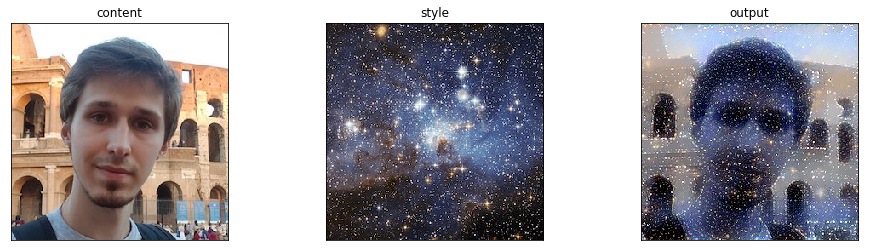

In [16]:
content_image = load_image('images/face.jpg')
style_image = load_image('images/space.jpg')

style_weights = 2e10 * np.array([1000.0, 100.0, 100.0, 10.0])
output_image = style_transfer(content_image, style_image, style_weights, tv_weight=20, iterations=1000)
plot_images([content_image, style_image, output_image], titles=['content', 'style', 'output'])